# Testing XGB on well log datasets 

In [3]:
import numpy as np
import pandas as pd

from coremdlr.datasets import WellLoader, FaciesDataset
from coremdlr.models import FeaturePredictor, LambdaModel

In [4]:
from coremdlr.datasets.utils import available_wells

wells = list(available_wells())
wells, len(wells)

(['204-20a-7',
  '204-19-3A',
  '204-19-7',
  '204-20-6a',
  '204-19-6',
  '204-24a-7',
  '205-21b-3',
  '204-24a-6',
  '204-20-1',
  '204-20-1Z',
  '204-20-3',
  '204-20-2'],
 12)

### Picking your training and testing wells

In [17]:
fdset = FaciesDataset(wells[:10], test_wells=wells[10:],
                    features=["logs"],
                    label_resolution=32*100, # 32 pixels ~ .5cm
                    logs_args={'scaler_kind': 'standard'})

In [18]:
fdset.load_or_generate_data()

Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (35,)), ('top', (35,)), ('base', (35,)), ('logs', (35, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (94,)), ('top', (94,)), ('base', (94,)), ('logs', (94, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (103,)), ('top', (103,)), ('base', (103,)), ('logs', (103, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (37,)), ('top', (37,)), ('base', (37,)), ('logs', (37, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (20,)), ('top', (20,)), ('base', (20,)), ('logs', (20, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (200,)), ('top', (200,)), ('base', (200,)), ('logs', (200, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (42,)), ('top', (42,)), ('base', (42,)), ('logs', (42, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (140,)), ('top', (140,)), ('base', (140,)), ('logs', (140, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (122,)), ('top', (122,)), ('base', (122,)), ('logs', (122, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (21,)), ('top', (21,)), ('base', (21,)), ('logs', (21, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (113,)), ('top', (113,)), ('base', (113,)), ('logs', (113, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (32,)), ('top', (32,)), ('base', (32,)), ('logs', (32, 11))]


In [1]:
import hyperopt

from hyperopt import hp
from hyperopt.pyll.base import scope
from sklearn.metrics import f1_score, log_loss
from sklearn.utils.class_weight import compute_sample_weight

# for balanced log_loss computation
sample_weights = compute_sample_weight('balanced', fdset.y_test) 

fmodel_args = {
    'logs': {
        'model': 'LambdaModel',
        'model_args': {'feature': 'logs'}
    }
}

XGB_SEARCH_SPACE = {
    'model_type' : 'XGB',
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'objective' : 'multi:softprob',
    'n_jobs' : 2,
    'gamma' : hp.uniform('gamma', 0, 0.5),
    'subsample' : hp.uniform('subsample', 0.3, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1.0),
    'colsample_bylevel' : 1,
    'reg_alpha' : 0,                                    # L1 penalty
    'reg_lambda' : hp.uniform('reg_lambda', 0.1, 10),   # L2 penalty
    'tree_method' : 'gpu_exact',
}

def train_xgb_model(model_config):
    """
    Train function given model_config dict of params.
    """
    xgb_predictor = FeaturePredictor(fdset, model_args=model_config, feature_model_args=fmodel_args)
    test_acc = xgb_predictor.fit(fdset, verbose=False)
    y_pred = xgb_predictor.predict(fdset.X_test)
    print('F1 score:', f1_score(fdset.y_test, y_pred, average='macro'))
    return log_loss(fdset.y_test, xgb_predictor.predict_proba(fdset.X_test), sample_weight=sample_weights)


def make_params_usable(params):
    """
    Convert params returned by hyperopt to usable `model_args`
    """
    return {
        **XGB_SEARCH_SPACE,
        **params,
        **{'max_depth' : int(params['max_depth']),
           'n_estimators' : int(params['n_estimators'])}
    }

NameError: name 'fdset' is not defined

In [ ]:



best_params = hyperopt.fmin(
    fn=train_xgb_model,
    space=XGB_SEARCH_SPACE,
    algo=hyperopt.rand.suggest,
    max_evals=50
)

In [9]:
best_params

{'colsample_bytree': 0.8031868709399381,
 'gamma': 0.11565501476507895,
 'learning_rate': 0.014375290475924927,
 'max_depth': 3.0,
 'n_estimators': 303.0,
 'reg_lambda': 8.11357005542322,
 'subsample': 0.6873088322883658}

In [10]:
params = {
    **XGB_SEARCH_SPACE, 
    **best_params, 
    **{'max_depth' : int(best_params['max_depth']), 
       'n_estimators' : int(best_params['n_estimators'])}
}
xgb_predictor = FeaturePredictor(fdset, model_args=params, feature_model_args=fmodel_args)
xgb_predictor.fit(fdset, verbose=True)

imps = list(zip(fdset.wells[0].logs_args['which_logs'], xgb_predictor.model.feature_importances_))
imps.sort(key = lambda p: p[1])
for pair in imps[::-1]:
    print(pair)

Training model for feature:  logs
                      precision    recall  f1-score   support

           sandstone       0.48      0.32      0.38      1979
clay-prone sandstone       0.08      0.36      0.13       332
      sandy mudstone       0.15      0.03      0.05       341
          oilstained       0.65      0.54      0.59      2269
            mudstone       0.13      0.17      0.15       816

           micro avg       0.37      0.37      0.37      5737
           macro avg       0.30      0.28      0.26      5737
        weighted avg       0.46      0.37      0.40      5737

Total accuracy Score :  0.3705769565975248
Confusion Matrix: 
 [[ 631  701   36  368  243]
 [  32  118    0   49  133]
 [  20  101   10   66  144]
 [ 573   83    6 1228  379]
 [  46  433   16  182  139]]
('RDEP', 0.13829175)
('SP', 0.13262956)
('GR', 0.1)
('DENS', 0.09942418)
('RSHAL', 0.085412666)
('PEF', 0.08445297)
('DTS2', 0.078982726)
('DTS', 0.078982726)
('DTS1', 0.0756238)
('DTC', 0.07476008)
('

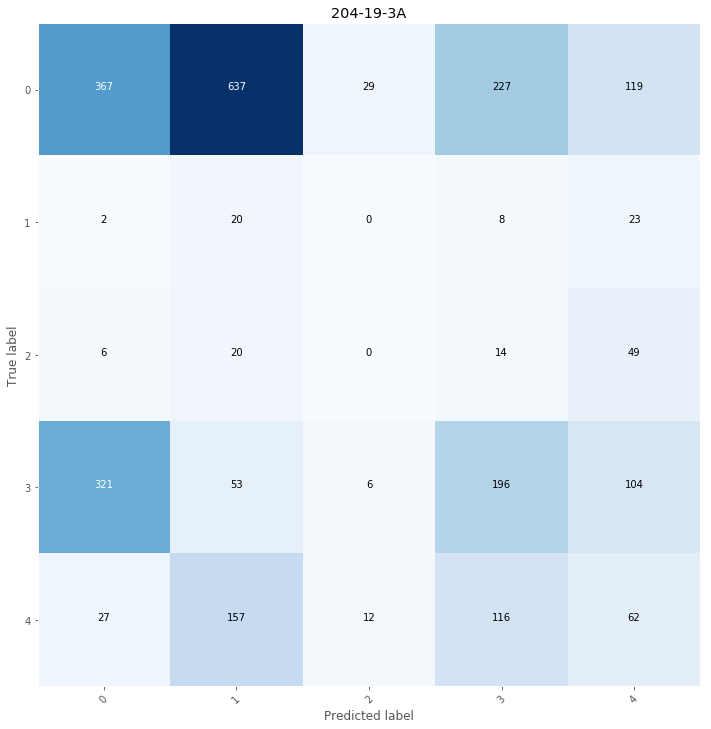

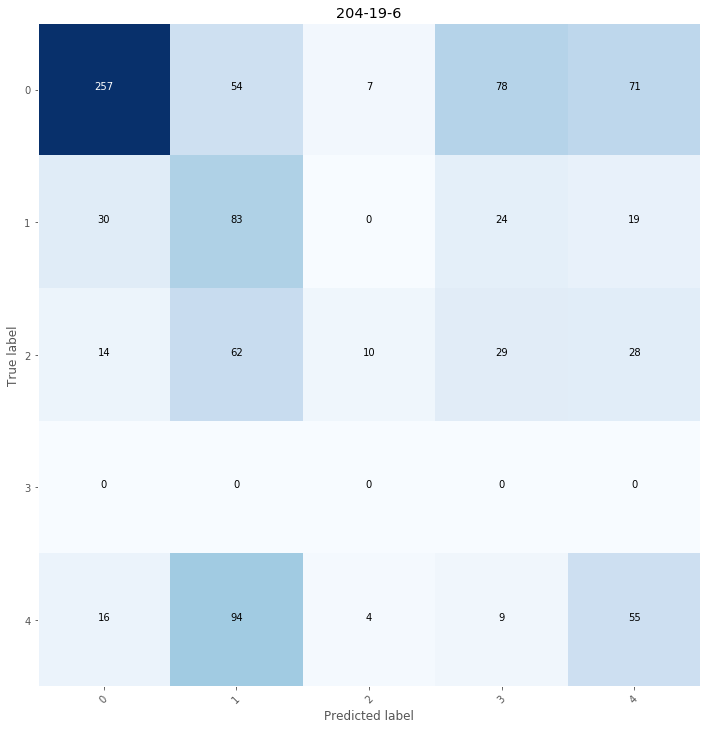

In [20]:
import matplotlib.pyplot as plt
from coremdlr.viz import model_plots 

pred_dfs = []

for test_well_name in fdset.test_well_names:
    df = xgb_predictor.preds_dataframe(test_well_name, logs=fdset.logs_args['which_logs'])
    df['well'] = test_well_name
    
    fig, ax = plt.subplots(figsize=(10,10))
    model_plots.confusion_matrix_plot(df, fdset.classes, title=test_well_name, ax=ax)
    
    pred_dfs.append(df)
    
pred_df = pd.concat(pred_dfs)

In [21]:
fdset.classes

['sandstone',
 'clay-prone sandstone',
 'sandy mudstone',
 'oilstained',
 'mudstone']